In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda, Concatenate
from keras.layers.merge import Multiply
from keras.models import Model
from keras.losses import mean_squared_error, binary_crossentropy
from keras.models import Model
import keras.backend as K
from sklearn.metrics import mean_squared_error as mse

Using TensorFlow backend.


# Right now make as many assumptions as possible

It's better to ask it
- derive speeds
- separate x and y. mby use same module for both?
- learn bounces separately
     - is LSTM much better if there is only 1 frame after the bounce vs 0?

In [2]:
def save_model(model, model_str):
    model_json = model.to_json()
    with open('trained/'+model_str+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('trained/'+model_str+".h5")
    print("Saved model to disk")

In [3]:
## Straight movement, derive speed

from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda

# This returns a tensor
inputs = Input(shape=(4,1,))
# inputs = Input(shape=(10,1))

# a layer instance is callable on a tensor, and returns a tensor
x = LSTM(4, return_sequences=False)(inputs)
x = Dense(2)(x)

predictions = x#Dense(2, input_shape=(4,1))(x)

# This creates a model that includes
# the Input layer and three Dense layers
model_ws = Model(inputs=inputs, outputs=predictions)
model_ws.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_ws.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________


In [4]:
from Generators import fmove_generator, bounce_generator, bmove_generator, bounce2_move_generator

In [5]:
def mod_gen(batch_size=128):
    while True:
        for a in fmove_generator(batch_size=batch_size):
            yield a[:,:4,0].reshape(batch_size,-1,1), a[:,4,:2]

In [6]:
next(mod_gen(batch_size=2))

(array([[[-1.11935645],
         [-1.09438133],
         [-1.06940622],
         [-1.0444311 ]],
 
        [[-1.12514605],
         [-1.07018895],
         [-1.01523185],
         [-0.96027475]]]), array([[-1.01945598,  0.02497512],
        [-0.90531765,  0.0549571 ]]))

In [7]:
model_ws.fit_generator(mod_gen(), steps_per_epoch=10000, epochs=5) #loss: 1.7196e-06 - acc: 0.9999

Epoch 1/5
10000/10000 [==============================] - 44s 4ms/step - loss: 0.0315 - acc: 0.9721
Epoch 2/5
10000/10000 [==============================] - 42s 4ms/step - loss: 1.9551e-05 - acc: 0.9990
Epoch 3/5
10000/10000 [==============================] - 42s 4ms/step - loss: 4.5094e-06 - acc: 0.9996
Epoch 4/5
10000/10000 [==============================] - 42s 4ms/step - loss: 2.3265e-06 - acc: 0.9998
Epoch 5/5
10000/10000 [==============================] - 42s 4ms/step - loss: 1.6584e-06 - acc: 0.9998


In [9]:
model_ws.predict_generator(mod_gen(), steps=1000).shape

(128000, 2)

In [10]:
import matplotlib.pyplot as plt

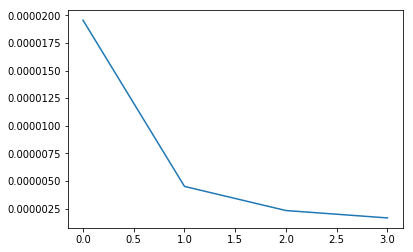

In [11]:
plt.plot(model_ws.history.history['loss'][1:])

In [12]:
train_X, train_Y = next(mod_gen(batch_size=1024))

In [13]:
mse(train_Y, model_ws.predict(train_X))**0.5

0.0008630517766002361

In [72]:
# save_model(model_ws, 'model_ws')

# Last frame is after bounce. Cross train with previous.

 loss: 5.1515e-04 - acc: 0.9969 with 4 hidden units on lstm
 
 loss: 2.5119e-04 - acc: 0.9978 with 8 hidden units

In [14]:
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda

inputs = Input(shape=(4,1,))
x = LSTM(8, return_sequences=False)(inputs)
x = Dense(2)(x)
predictions = x#Dense(2, input_shape=(4,1))(x)
model_ws = Model(inputs=inputs, outputs=predictions)
model_ws.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_ws.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 338
Trainable params: 338
Non-trainable params: 0
_________________________________________________________________


In [15]:
a = next(fmove_generator())
b = next(bmove_generator(bounceAt=2)) 
print(a.shape, b.shape)

(64, 5, 4) (64, 5, 4)


In [16]:
np.append(a, b, axis=0).shape

(128, 5, 4)

In [17]:
def gen_cross(batch_size=128):
    "Cross train to consider a bounce"
    while True:
        a = next(fmove_generator(batch_size=int(batch_size/4)))
        b = next(bmove_generator(batch_size=int(batch_size/4),bounceAt=2)) #last training instance is after the bounce
        b1 = next(bmove_generator(batch_size=int(batch_size/4),bounceAt=1))
        b2 = next(bmove_generator(batch_size=int(batch_size/4),bounceAt=0))
        c = np.append(a, b, axis=0)
        c = np.append(c, b1, axis=0)
        c = np.append(c, b2, axis=0)
        yield c[:,:4,0].reshape(batch_size,-1,1), c[:,4,:2]

In [18]:
model_ws.fit_generator(gen_cross(), steps_per_epoch=10000, epochs=100)

Epoch 1/100
10000/10000 [==============================] - 42s 4ms/step - loss: 0.0051 - acc: 0.9910
Epoch 2/100
10000/10000 [==============================] - 42s 4ms/step - loss: 6.2785e-04 - acc: 0.9909
Epoch 3/100
10000/10000 [==============================] - 42s 4ms/step - loss: 5.5718e-04 - acc: 0.9955
Epoch 4/100
10000/10000 [==============================] - 42s 4ms/step - loss: 5.1322e-04 - acc: 0.9975
Epoch 5/100
10000/10000 [==============================] - 43s 4ms/step - loss: 4.2215e-04 - acc: 0.9936
Epoch 6/100
10000/10000 [==============================] - 43s 4ms/step - loss: 3.5348e-04 - acc: 0.9858
Epoch 7/100
10000/10000 [==============================] - 43s 4ms/step - loss: 3.3225e-04 - acc: 0.9864
Epoch 8/100
10000/10000 [==============================] - 43s 4ms/step - loss: 3.1474e-04 - acc: 0.9872
Epoch 9/100
10000/10000 [==============================] - 43s 4ms/step - loss: 2.9544e-04 - acc: 0.9877
Epoch 10/100
10000/10000 [==============================] -

KeyboardInterrupt: 

In [153]:
# # # # save_model(model_ws, 'model_ws_100epochs') #took two hours

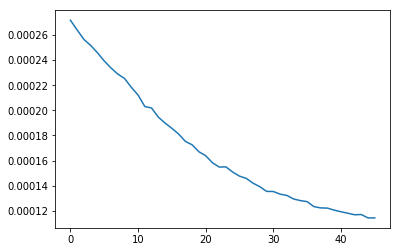

In [20]:
plt.plot(model_ws.history.history['loss'][10:])

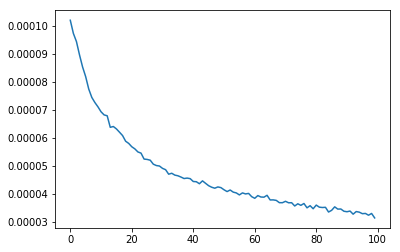

In [136]:
plt.plot(model_ws.history.history['loss']) #with mistake

In [137]:
import pandas as pd

In [27]:
### TODO:
### MISTAKE on generating
t = b2[0].reshape(1,5,4)
pd.DataFrame(t[0])

,0,1,2,3
0,0.044515,-0.067232,0.258614,-0.046601
1,0.022718,0.067232,0.212013,-0.046601
2,0.089950,0.067232,0.165412,-0.046601
3,0.157182,0.067232,0.118812,-0.046601
4,0.224415,0.067232,0.072211,-0.046601


In [28]:
model_ws.predict(t[:,:4,0].reshape(1,4,1))

array([[0.22436628, 0.06719185]], dtype=float32)

In [26]:
batch_size=128
a = next(fmove_generator(batch_size=int(batch_size/4)))
b = next(bmove_generator(batch_size=int(batch_size/4),bounceAt=2)) #last training instance is after the bounce
b1 = next(bmove_generator(batch_size=int(batch_size/4),bounceAt=1))
b2 = next(bmove_generator(batch_size=int(batch_size/4),bounceAt=0))

# Next frame

model_ws predicts next frame with speed. Use that to predict from one frame only?

# Bounces

In [73]:
#for predicting multiple frames, bounce module need the ability 
#             to mirror movement wherever the bounce is
inputs = Input(shape=(2,))

x = Dense(2)(inputs)
x = Dense(4, activation='relu')(x)
x = Dense(2)(x)
predictions = x


model_b = Model(inputs=inputs, outputs=predictions)
model_b.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 10        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [77]:
def mod_bounce(batch_size=128):
    while True:
        for a in bmove_generator(batch_size=batch_size, bounceAt=3): #4th frame is after bounce
            yield a[:,:4,0].reshape(batch_size,-1,1), a[:,4,:2]

In [80]:
x,y = next(mod_bounce())

In [13]:
save_model(model_b, 'model_b')

Saved model to disk


In [14]:
print(mse(test_Y, model_b.predict(test_X))**0.5)
print(mse(train_Y, model_b.predict(train_X))**0.5)

2.541683286868845e-05
2.526100590037306e-05


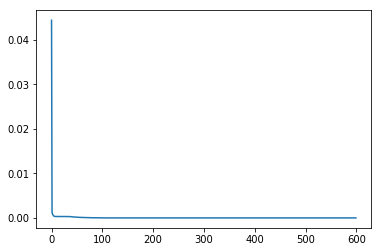

In [15]:
plt.plot(model_b.history.history['loss'])

In [16]:
train_X[:5]

array([[ 1.06517512,  0.091181  ],
       [-0.00969421, -0.01684606],
       [ 1.00933562,  0.09554047],
       [-0.02180216, -0.07631796],
       [ 1.05431459,  0.07958159]])

In [17]:
model_b.predict(train_X[:5])

array([[ 0.93479025, -0.09119433],
       [ 0.00966617,  0.01684713],
       [ 0.99061376, -0.09555367],
       [ 0.02176878,  0.07632011],
       [ 0.94564986, -0.07959476]], dtype=float32)

In [18]:
train_Y[[0,1]]

array([[ 0.93482488, -0.091181  ],
       [ 0.00969421,  0.01684606]])

In [19]:
save_model(model_b, 'model_b')

Saved model to disk


### Attention

In [20]:
inputs = Input(shape=(1,))
x = Dense(8)(inputs)
x = Dense(20, activation='relu')(x)
x = Dense(2, activation='softmax')(x)
predictions = x

model_att = Model(inputs=inputs, outputs=predictions)
model_att.compile(loss=binary_crossentropy,
              optimizer='adamax',
              metrics=['accuracy'])
model_att.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_6 (Dense)              (None, 20)                180       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 42        
Total params: 238
Trainable params: 238
Non-trainable params: 0
_________________________________________________________________


In [21]:
df = pd.read_csv('data/bounces_att.csv')
a = df.to_numpy()
train_X = a[:,0].reshape(20000,1)
train_Y = (a[:,2] == True)

l = train_X.shape[0]
i = np.arange(l)
t = np.zeros((l, 2))
t[:,0] = 1-train_Y
t[:,1] = train_Y
train_Y = t

model_att.fit(train_X, train_Y, epochs=100, verbose=False)

In [22]:
save_model(model_att, 'model_att')

Saved model to disk


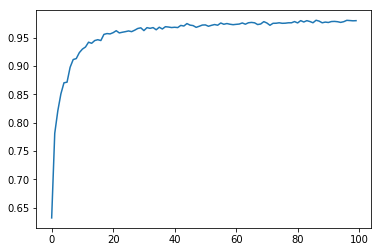

In [23]:
plt.plot(model_att.history.history['acc'])

In [24]:
inputs = Input(shape=(1,))

x = model_att(inputs)
x = Lambda(lambda s: K.round(s))(x)
predictions = x
model_lambda = Model(inputs=inputs, outputs=predictions)
model_lambda.compile(loss=binary_crossentropy,
              optimizer='adam',
              metrics=['acc'])
model_lambda.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
model_3 (Model)              (None, 2)                 238       
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
Total params: 238
Trainable params: 238
Non-trainable params: 0
_________________________________________________________________


In [25]:
save_model(model_lambda, 'model_lambda')

Saved model to disk


## Bounce series

In [26]:
df = pd.read_csv('data/bounces_x_1.csv')
a = df.to_numpy()
a = a.reshape((1000,5,4))

X = a[:,:4,0].reshape(1000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y = a[:,4,:2] #.reshape(10000,5,2)

train_X = X[:800]
train_Y = Y[:800]

test_X = X[800:]
test_Y = Y[800:]

In [27]:
isBounce = K.tf.convert_to_tensor([0,1],dtype=np.float32) #if attention outputs this, then bounce module is needed

inputs_rec = Input(shape=(4,1), name='input_rec')
rec = model_ws(inputs_rec)
rec_x = Lambda(lambda s: K.reshape(s[:,0], (-1,1)))(rec)
bnc = model_b(rec)
att = model_lambda(rec_x)
att2 = Lambda(lambda s: K.switch(K.equal(s[0], isBounce), s[1], s[2]))([att, bnc, rec]) #~hard attention

x = att2

model_m = Model(inputs=inputs_rec, outputs=x)
model_m.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_rec (InputLayer)          (None, 4, 1)         0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2)            106         input_rec[0][0]                  
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           model_1[1][0]                    
__________________________________________________________________________________________________
model_4 (Model)                 (None, 2)            238         lambda_2[0][0]                   
__________________________________________________________________________________________________
model_2 (M

In [28]:
save_model(model_m, 'model_m')

Saved model to disk


In [29]:
df2 = pd.read_csv('data/sim_data_borders.csv')
# x, x_vel, y, y_vel
a2 = df2.to_numpy()
a2 = a2.reshape((4000,5,4)) #samples x timesteps x features
X2 = a2[:,:4,0].reshape(4000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y2 = a2[:,4,:2] #.reshape(10000,5,2)

train_X2 = X2[:8000]
train_Y2 = Y2[:8000]

In [30]:
mixdf = pd.concat([df, df2[:5000]])
mix = mixdf.to_numpy()
mix = mix.reshape(2000,5,4)
np.random.shuffle(mix)
mix_train_x = mix[:1800,:4,0].reshape(1800,4,1)
mix_train_y = mix[:1800,4,:2]
mix_test_x = mix[1800:,:4,0].reshape(200,4,1)
mix_test_y = mix[1800:,4,:2]
mse(mix_test_y, model_m.predict(mix_test_x)) # My model

0.0010043797778884257